In [1]:
from sunpy.net import Fido, hek2vso, attrs as a
import sunpy.map
from sunpy.time import parse_time
import sunpy.timeseries
import sunpy.data.sample
from sunpy.coordinates import frames, get_horizons_coord, get_body_heliographic_stonyhurst
from sunpy.coordinates import SphericalScreen
from sunpy.coordinates.utils import get_rectangle_coordinates

from astropy import units as u
from astropy.coordinates import SkyCoord, SkyOffsetFrame
from astropy.visualization import AsymmetricPercentileInterval, ImageNormalize, LogStretch, AsinhStretch
from scipy.interpolate import interp1d

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import dates

import os

In [2]:
lines = [94, 131, 171, 193, 211, 304, 335]
images = os.listdir('images')
aia_maps = {}
for l in lines:
    tmp = []
    for filename in images:
        if filename.find(f'{l}A') != -1:
            tmp.append(sunpy.map.Map(f'images/{filename}'))
    aia_maps[l] = sunpy.map.Map(tmp, sequence=True)


In [3]:
xin, yin = np.loadtxt('wang_in_points.csv', delimiter=',').T
xout, yout = np.loadtxt('wang_out_points.csv', delimiter=',').T

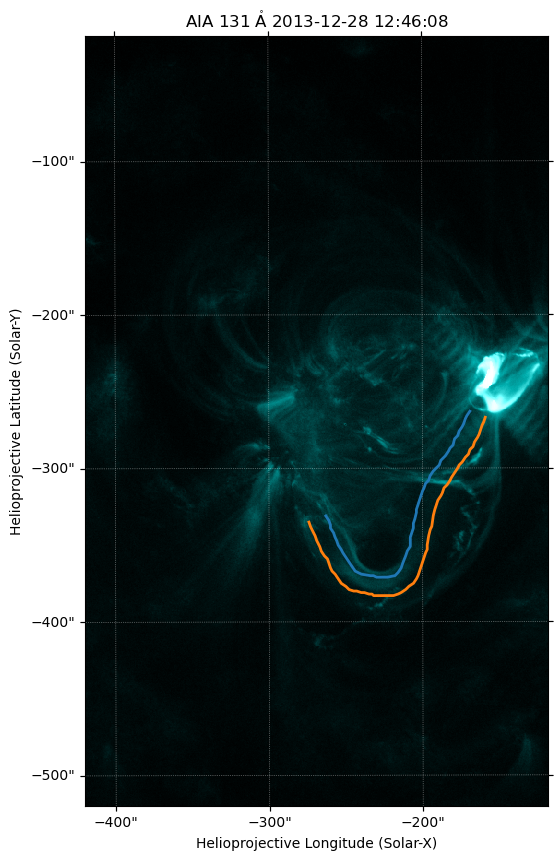

In [4]:
l = 131
n = 30
traced_in_loop = SkyCoord(
    Tx=xin*u.arcsec,
    Ty=yin*u.arcsec,
    frame=aia_maps[l][n].coordinate_frame,
)
traced_out_loop = SkyCoord(
    Tx=xout*u.arcsec,
    Ty=yout*u.arcsec,
    frame=aia_maps[l][n].coordinate_frame,
)
fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot(projection=aia_maps[l][n])
aia_maps[l][n].plot()
ax.plot_coord(traced_in_loop, lw=2)
ax.plot_coord(traced_out_loop, lw=2)

In [5]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

drs = np.zeros((2,len(xin)-1))
drs[0] = np.diff(np.array(xin))
drs[1] = np.diff(np.array(yin))
ts = [v/np.linalg.norm(v) for v in drs.T]
ts.append(ts[-1])
txs, tys = np.array(ts).T
preangles = np.arctan2(tys, txs)
angles = np.append(moving_average(preangles,7), preangles[-6:])
angles

array([-1.19866712, -1.19866712, -1.17839611, -1.09439574, -1.09439574,
       -1.05635973, -1.03859473, -0.92639499, -0.85223126, -0.71765983,
       -0.57726072, -0.50309699, -0.36269789, -0.22229879, -0.15606341,
       -0.06162868,  0.07416373,  0.21456283,  0.45923332,  0.62927474,
        0.80770985,  0.94810895,  1.14430906,  1.2565088 ,  1.29454481,
        1.29454481,  1.34890286,  1.34890286,  1.39790628,  1.39790628,
        1.35194192,  1.35194192,  1.35194192,  1.30597755,  1.28570654,
        1.27473913,  1.16253939,  1.16253939,  1.12450338,  1.05826801,
        0.99203264,  1.01230365,  0.94606827,  0.97426764,  0.95399663,
        0.92579727,  1.00300005,  1.00300005,  1.00300005,  1.03119942,
        1.04896442,  1.06923543,  1.11519979,  1.06619637,  1.09439574,
        0.98279372,  1.10714872,  1.24904577,  1.10714872,  0.98279372,
        0.98279372])

In [6]:
r = 12
x = np.round(xin + r*np.sin(angles))
y = np.round(yin - r*np.cos(angles))

traced_loop_2 = SkyCoord(
    Tx=x*u.arcsec,
    Ty=y*u.arcsec,
    frame=aia_maps[l][n].coordinate_frame,
)

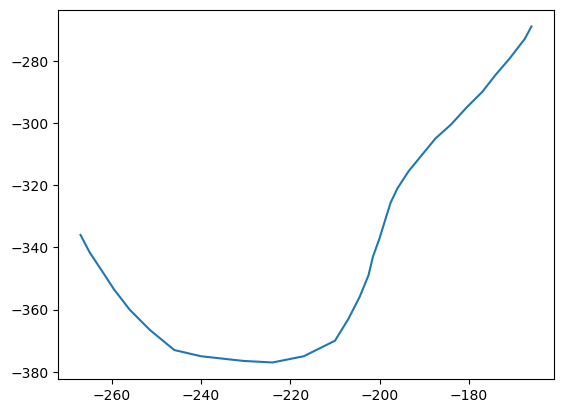

In [7]:
xout_filtered = np.zeros(len(xin))
yout_filtered = np.zeros(len(xin))
for i in range(len(x)):

    xout_filtered[i] = xout[np.argmin(np.sqrt((xout-x[i])**2+(yout-y[i])**2))]
    yout_filtered[i] = yout[np.argmin(np.sqrt((xout-x[i])**2+(yout-y[i])**2))]

height = int(np.round(np.min(np.array([np.linalg.norm(v) for v in np.array([xout_filtered-xin, yout_filtered-yin]).T])))) * u.arcsec
xs = ((xin[1::2] + xout_filtered[1::2])/2)[::-1]
ys = ((yin[1::2] + yout_filtered[1::2])/2)[::-1]
widths = np.round(np.array([np.linalg.norm(v) for v in np.array([np.diff((xin[::2] + xout_filtered[::2])/2), np.diff((yin[::2] + yout_filtered[::2])/2)]).T])[::-1]) * u.arcsec
ts = [v/np.linalg.norm(v) for v in np.array([np.diff((xin[::2] + xout_filtered[::2])/2), np.diff((yin[::2] + yout_filtered[::2])/2)]).T]
txs, tys = np.array(ts).T
preangles = np.arctan2(tys, txs)[::-1]
plt.plot(xs, ys)

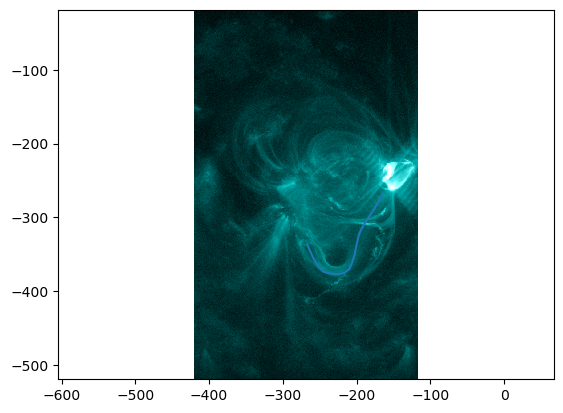

In [8]:
n = 30
xgrid = np.linspace(aia_maps[l][n].bottom_left_coord.Tx.value, aia_maps[l][n].top_right_coord.Tx.value, aia_maps[l][n].data.shape[1])
ygrid = np.linspace(aia_maps[l][n].bottom_left_coord.Ty.value, aia_maps[l][n].top_right_coord.Ty.value, aia_maps[l][n].data.shape[0])
plt.pcolormesh(xgrid, ygrid, aia_maps[l][n].data,
               norm=ImageNormalize(stretch=LogStretch()), cmap=f'sdoaia{l}')
plt.plot(xs,ys)
plt.xlim(aia_maps[l][n].bottom_left_coord.Tx.value, aia_maps[l][n].top_right_coord.Tx.value)
plt.ylim(aia_maps[l][n].bottom_left_coord.Ty.value, aia_maps[l][n].top_right_coord.Ty.value)
plt.axis('equal')
plt.show()

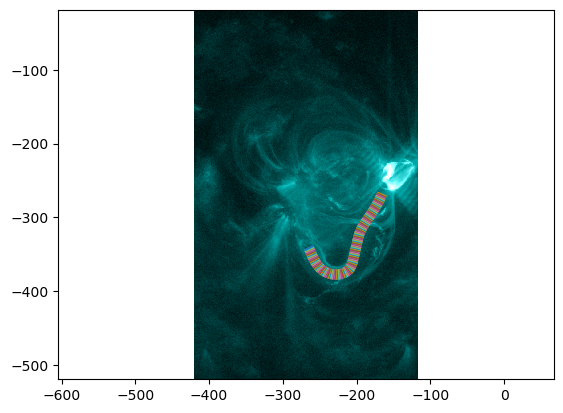

<Angle [0.        , 0.00026041, 0.00052086, 0.00078133, 0.00104182,
        0.00130233, 0.00156285, 0.00182339, 0.00208394, 0.00234449,
        0.00260505, 0.0028656 , 0.00312616, 0.00338672, 0.00364727,
        0.00390782, 0.00416837, 0.0044289 , 0.00468943, 0.00494995,
        0.00521046, 0.00547097, 0.00573147, 0.00599195, 0.00625244,
        0.00651292, 0.00677339, 0.00703387, 0.00729435, 0.00755485,
        0.00781536, 0.00807589, 0.00833643, 0.00859698, 0.00885753,
        0.00911809, 0.00937864, 0.00963917, 0.00989969, 0.01016018,
        0.01042064, 0.01068107, 0.01094149, 0.01120189, 0.01146228,
        0.01172267, 0.01198308, 0.01224351, 0.01250398, 0.01276449,
        0.01302507, 0.01328574, 0.01354652, 0.01380742, 0.01406848,
        0.01432964, 0.01459081, 0.01485188, 0.01511279, 0.01537349,
        0.01563393, 0.01589411, 0.01615403, 0.01641374, 0.0166733 ,
        0.01693282, 0.01719243, 0.01745224, 0.01771232, 0.01797271,
        0.01823339, 0.01849434, 0.0187555 , 0.01

In [9]:
from scipy.interpolate import CubicSpline
from scipy.integrate import quad
ts = np.linspace(0,1,len(xs))
xpre = CubicSpline(ts[::2], xs[::2])
ypre = CubicSpline(ts[::2], ys[::2])
dl = lambda s: np.sqrt(xpre(s,1)**2+ypre(s,1)**2)
lengths = []
for ti in ts[::2]:
    lengths.append(quad(dl, 0, ti, limit=100)[0])
tsnew = np.array(lengths)/max(lengths)

x = CubicSpline(tsnew, xs[::2])
y = CubicSpline(tsnew, ys[::2])
t = np.linspace(0,1,200)
dlnew = lambda s: np.sqrt(x(s,1)**2+y(s,1)**2)
tanvec = lambda s: np.array([x(s,1), y(s,1)])
tanvecnorm = lambda s: tanvec(s)/np.linalg.norm(tanvec(s))
normvec =  lambda s: np.array([tanvecnorm(s)[1], -tanvecnorm(s)[0]])
slicex = lambda s: np.array([x(s)-0.5*height.value*normvec(s)[0], x(s)+0.5*height.value*normvec(s)[0]])
slicey = lambda s: np.array([y(s)-0.5*height.value*normvec(s)[1], y(s)+0.5*height.value*normvec(s)[1]])

plt.pcolormesh(xgrid, ygrid, aia_maps[l][n].data,
               norm=ImageNormalize(stretch=LogStretch()), cmap=f'sdoaia{l}')
plt.plot(x(t), y(t))
for ti in t:
    plt.plot(slicex(ti), slicey(ti))
plt.xlim(aia_maps[l][n].bottom_left_coord.Tx.value, aia_maps[l][n].top_right_coord.Tx.value)
plt.axis('equal')
plt.show()

new_loop = SkyCoord(Tx=x(t)*u.arcsec, Ty=y(t)*u.arcsec, frame=aia_maps[l][n].coordinate_frame)
predistances = new_loop.separation(new_loop[0])
predistances[1:] = [new_loop[i].separation(new_loop[i-1]) for i in range(1,len(x(t)))]
distances = np.cumsum(predistances)
distances

In [ ]:
def line_to_pixels_with_values(image, grid_x, grid_y, control_x, control_y):
    
        
    dx = np.diff(np.round(image.shape[1]*(control_x-grid_x[0])/(grid_x[-1]-grid_x[0])))[0]
    dy = np.diff(np.round(image.shape[0]*(control_y-grid_y[0])/(grid_y[-1]-grid_y[0])))[0]
    num_points = np.round(np.sqrt(dx**2+dy**2)).astype(int)
    t = np.linspace(0, 1, len(control_x))
    t_new = np.linspace(0, 1, num_points)
    lx = interp1d(t, control_x)
    ly = interp1d(t, control_y)
    x = lx(t_new)
    y = ly(t_new)
    x_pixels = np.round(image.shape[1]*(x-grid_x[0])/(grid_x[-1]-grid_x[0])).astype(int)
    y_pixels = np.round(image.shape[0]*(y-grid_y[0])/(grid_y[-1]-grid_y[0])).astype(int)
    
    
    # pixel_coords = []
    pixel_values = []
    for i in range(num_points):
        if 0 <= x_pixels[i] < image.shape[1] and 0 <= y_pixels[i] < image.shape[0]:
            # pixel_coords.append((x_pixels[i], y_pixels[i]))
            pixel_values.append(image[y_pixels[i], x_pixels[i]])
        else:
            # pixel_coords.append(None)
            pixel_values.append(None)
    
    # return pixel_coords, pixel_values
    return pixel_values

intensity_stack = {}
time_array = np.array([m.date.tai_seconds for m in aia_maps[l]])-aia_maps[l][0].date.tai_seconds
for l in lines:
    intensity_stack[str(l)] = []
    for i in range(len(aia_maps[l])):
        prevalues = [line_to_pixels_with_values(aia_maps[l][i].data, xgrid, ygrid, slicex(ti), slicey(ti)) for ti in t]
        # weights = [np.exp((-((np.linspace(0,1,len(v))-0.5)*height.value)**2)/2)/np.sum(np.exp(-(np.linspace(0,1,len(v))-0.5)**2)) for v in prevalues]
        # intensity_stack[str(l)].append([np.dot(w,v) for w, v in zip(weights, prevalues)])
        intensity_stack[str(l)].append([np.mean(v) for v in prevalues])
    intensity_stack[str(l)] = np.array(intensity_stack[str(l)])
    # plt.matshow(np.array(intensity_stack[str(l)]).T, cmap=f'sdoaia{l}')
    # plt.show()

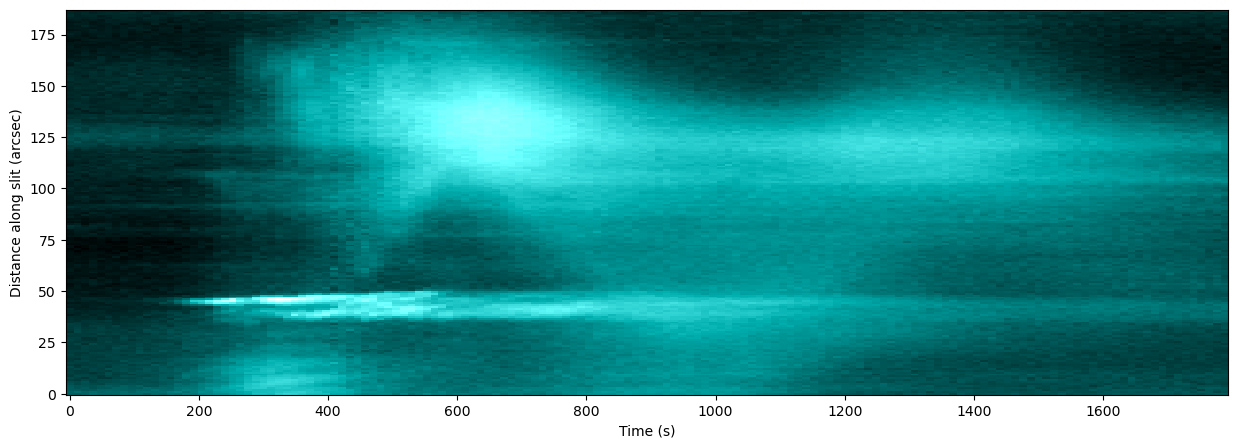

In [39]:
l = lines[1]
fig, ax = plt.subplots(figsize=(15, 5))
plt.pcolormesh(time_array, distances.to(u.arcsec).value, intensity_stack[str(l)].T,
               norm=ImageNormalize(stretch=AsinhStretch()), cmap=f'sdoaia{l}')

ax.set_ylabel("Distance along slit (arcsec)")
ax.set_xlabel("Time (s)")
plt.show()

intensity_stack['dist'] = distances.to(u.arcsec).value
intensity_stack['w'] = height.value
# np.savez('final_results.npz', **intensity_stack)